# Camera Motion

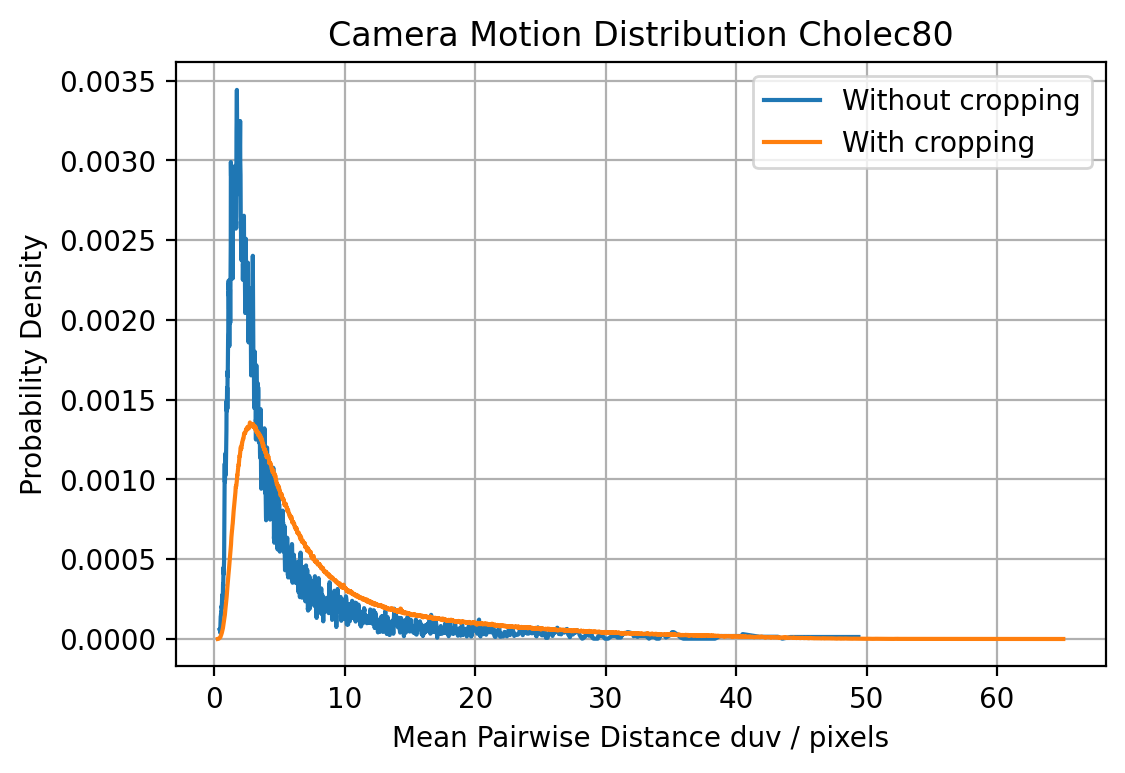

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

logs = {
    "Without cropping": "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_frames/pre_processed_5th_frame_log.pkl",
    "With cropping": "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/pre_processed_5th_frame_log_new.pkl"
}

for key in logs:
    log = logs[key]
    data_df = pd.read_pickle(log)
    # https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
    # label_df = pd.read_pickle("/media/martin/Samsung_T5/data/endoscopic_data/cholec80_frames/pre_processed_log_test_train_labels.pkl")

    data_df.duv_mpd = data_df.duv_mpd.round(decimals=2)
    # data_df['duv_mpd_ra'] = data_df.duv_mpd.rolling(25).mean()
    # data_df.duv_mpd_ra = data_df.duv_mpd_ra.round(decimals=2)

    # # for phase>
    # phases = label_df.Phase.unique()

    # Frequency
    # stats_data_df = data_df.groupby('duv_mpd_ra')['duv_mpd_ra'].agg('count').pipe(pd.DataFrame).rename(columns = {'duv_mpd_ra': 'frequency'})
    stats_data_df = data_df.groupby('duv_mpd')['duv_mpd'].agg('count').pipe(pd.DataFrame).rename(columns = {'duv_mpd': 'frequency'})
    # Pdata_df
    stats_data_df['pdata_df'] = stats_data_df['frequency'] / sum(stats_data_df['frequency'])

    stats_data_df.pdata_df = stats_data_df.pdata_df.rolling(5).mean()
    stats_data_df = stats_data_df.reset_index()

    # stats_data_df.plot(x='duv_mpd_ra', y='pdata_df', grid=True)~
    # stats_data_df.plot(x='duv_mpd', y='pdata_df', grid=True)
    plt.plot(stats_data_df.duv_mpd, stats_data_df.pdata_df, label=key)

plt.grid()
plt.legend()
plt.title("Camera Motion Distribution Cholec80")
plt.xlabel("Mean Pairwise Distance duv / pixels")
plt.ylabel("Probability Density")
plt.show()


# Camera Motion by Phase

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_29129/3537407981.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_df.duv_mpd = phase_df.duv_mpd.apply(lambda x: np.nan if np.isnan(x).any() else x)
100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


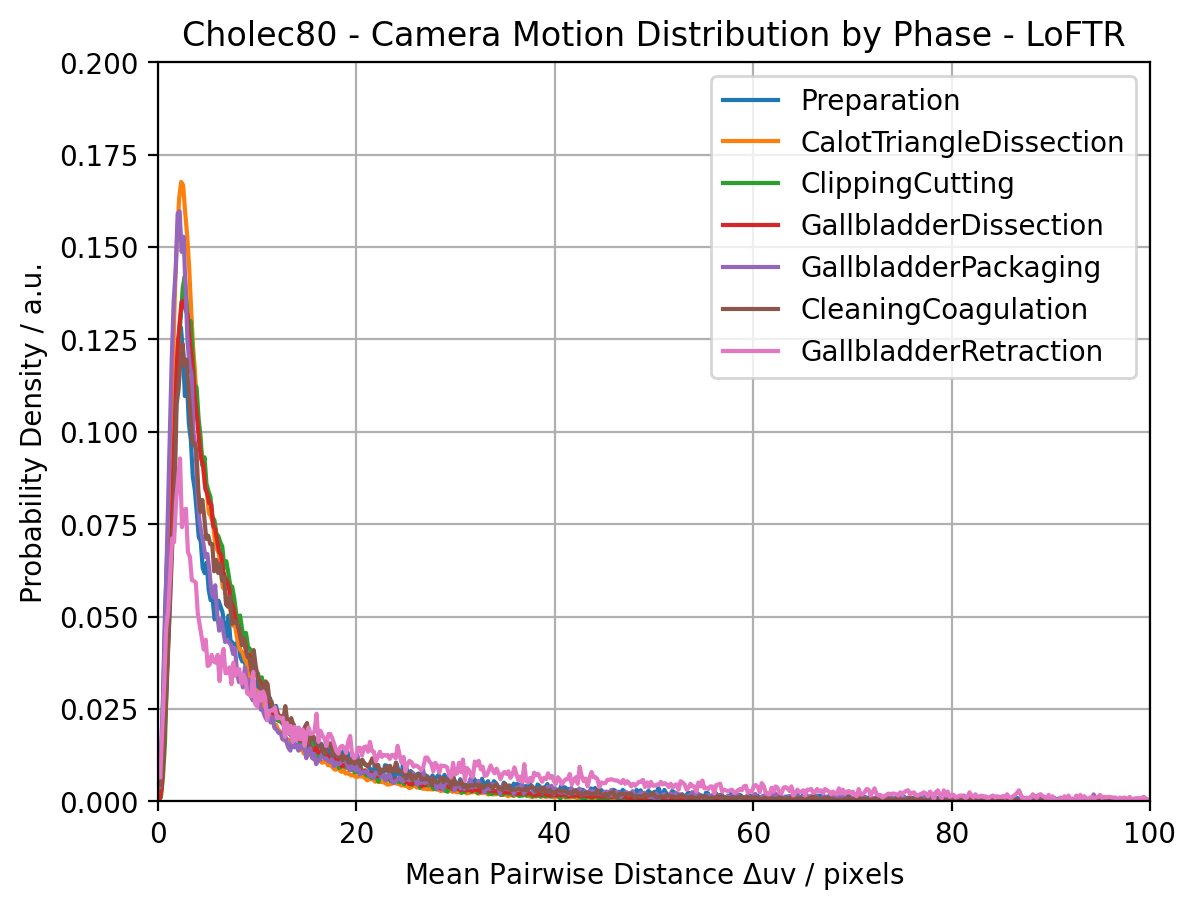

In [40]:
# data_df.hist("duv_mpd", bins=500)
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import numpy as np
import pandas as pd

target_phase_id = None
method = "loftr"

if target_phase_id is not None:
    motion_pkls = [
        "22_11_09_deep_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_no_nan.pkl",
        "22_11_09_loftr_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_no_nan.pkl"
    ]
    label_pkls = [
        "22_11_09_deep_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_labels_no_nan.pkl",
        "22_11_09_loftr_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_labels_no_nan.pkl"
    ]
    for motion_pkl, label_pkl in zip(motion_pkls, label_pkls):
        data_df = pd.read_pickle(f"/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/{motion_pkl}")
        label_df = pd.read_pickle(f"/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/{label_pkl}")

        # for phase>
        duv_max = 100
        phases = label_df.Phase.unique()

        phase = phases[target_phase_id]
        phase_df = data_df[label_df.Phase == phase]
        phase_df.duv_mpd = phase_df.duv_mpd.apply(lambda x: np.nan if np.isnan(x).any() else x)
        phase_df = phase_df.dropna()
        phase_df = phase_df[phase_df.duv_mpd < duv_max]

        hist, edges = np.histogram(phase_df.duv_mpd, bins=500, density=True)
        plt.plot(edges[:-1], hist, label=phase)

else:
    # also deep!
    motion_pkl = f"22_11_09_{method}_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_no_nan.pkl"
    label_pkl = f"22_11_09_{method}_pre_processed_frame_increment_5_frames_between_clips_5_log_test_train_labels_no_nan.pkl"

    data_df = pd.read_pickle(f"/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/{motion_pkl}")
    label_df = pd.read_pickle(f"/media/martin/Samsung_T5/data/endoscopic_data/cholec80_single_video_frames_cropped/{label_pkl}")

    # # drop non-existend videos from labels
    # unique_vid = data_df.vid.unique()
    # label_df 

    # data_df = data_df.dropna()

    # for phase>
    duv_max = 100
    phases = label_df.Phase.unique()

    for phase in tqdm(phases):
        phase_df = data_df[label_df.Phase == phase]
        phase_df.duv_mpd = phase_df.duv_mpd.apply(lambda x: np.nan if np.isnan(x).any() else x)
        phase_df = phase_df.dropna()
        phase_df = phase_df[phase_df.duv_mpd < duv_max]

        hist, edges = np.histogram(phase_df.duv_mpd, bins=500, density=True)
        plt.plot(edges[:-1], hist, label=phase)

plt.ylim([0, 0.2])
plt.xlim([0, duv_max])
if method == "deep":
    plt.title(r"Cholec80 - Camera Motion Distribution by Phase - Resnet34")
if method == "loftr":
    plt.title(r"Cholec80 - Camera Motion Distribution by Phase - LoFTR")
plt.xlabel(r"Mean Pairwise Distance $\Delta$uv / pixels")
plt.ylabel(r"Probability Density / a.u.")
plt.legend()
plt.grid()
plt.show()

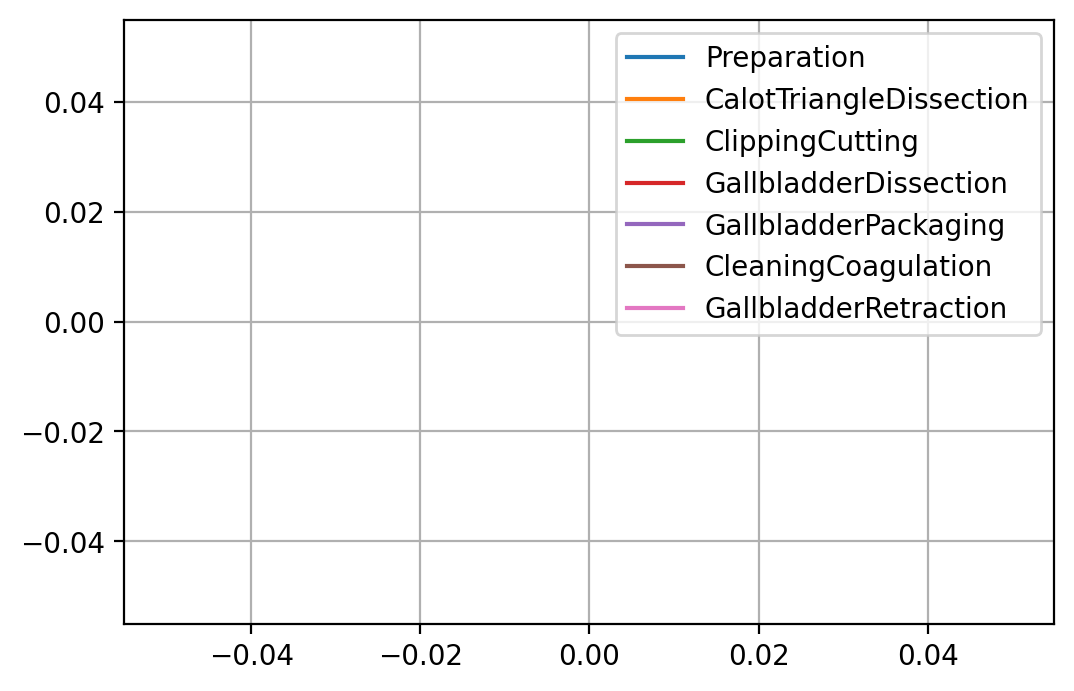

In [25]:
# for phase>
phases = label_df.Phase.unique()

data_df['duv_mpd_ra'] = data_df.duv_mpd.rolling(25).mean()
data_df.duv_mpd_ra = data_df.duv_mpd_ra.round(decimals=2)

for phase in phases:
    phase_data_df = data_df[label_df.Phase == phase]

    # Frequency
    stats_data_df = phase_data_df.groupby('duv_mpd_ra')['duv_mpd_ra'].agg('count').pipe(pd.DataFrame).rename(columns = {'duv_mpd_ra': 'frequency'})
    # Pdata_df
    stats_data_df['pdata_df'] = stats_data_df['frequency'] / sum(stats_data_df['frequency'])

    stats_data_df.pdata_df = stats_data_df.pdata_df.rolling(5).mean()
    stats_data_df = stats_data_df.reset_index()

    # stats_data_df.plot(x='duv_mpd_ra', y='pdata_df', grid=True, label=phase)
    plt.plot(stats_data_df.duv_mpd_ra, stats_data_df.pdata_df, label=phase)

plt.legend()
plt.grid()
plt.show()

In [ ]:
# sample videos with motion being equally probable

from torch.utils.data import DataLoader
# from datasets import ImageSequenceDataset

th = 19 # pixels
# prefix = ""
# ds = ImageSequenceDataset(
#     data_df[data_df.duv_mpd_ra > th],

# )

for _, row in data_df[data_df.duv_mpd_ra > th].iterrows():
    print(row.folder, row.frame, row.file)

# print(len(data_df[data_df.vid == 56]))
# print(data_df[data_df.vid == 57])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

frames = [
    "131465",
    "131466",
    "131467",
    "131468",
    "131469"
]

for frame in frames:
    img = np.load("/tmp/sorted/frame_{}.npy".format(frame))
    cv2.imshow("img", img)
    cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
import pandas as pd

df = pd.read_pickle("/media/martin/Samsung_T5/data/endoscopic_data/cholec80_frames/log.pkl")
len(df[df.vid==57])